# Computational Modeling of Enzymatic Degradation

Before beginning, please run the below cells before beginning or else nothing will work! As before, click in the cell and press either "shift+enter" or "shift+return" to run the cell

In [9]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
from scipy.stats import levy_l
from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline

def MM_Eval(S,P,kcat,E0,KM, time, ax1, clear_ax=False):

    #times
    step = 0.1
    stop = time
    t_eval = np.arange(0, stop, step)

    F = lambda t, S: -kcat*E0*S/(S+KM)

    sol = solve_ivp(F, [0,stop], [S], t_eval=t_eval)

    #fig1,ax1 = plt.subplots()
    if clear_ax == True:
        ax1.cla()
    ax1.plot(sol.t, sol.y[0], label='Substrate')
    ax1.plot(sol.t, S-sol.y[0], label='Product')
    ax1.set_title('Enzyme Reaction')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Concentration (moles/L)')
    ax1.legend()

def MM_2D(S, E0_range, KM_range, intervals = 50):

    #initial conditions
    S = 1.0
    
    #parameters
    kcat = 1
    term_val = 0.01
    num_intervals = intervals
    [E0_start,E0_end] = E0_range
    [KM_start, KM_end] = KM_range
    E0_step = (E0_end - E0_start)/(num_intervals-1)
    KM_step = (KM_end - KM_start)/(num_intervals-1)
    
    E0s = np.arange(E0_start, E0_end+E0_step, E0_step)
    KMs = np.arange(KM_start, KM_end+KM_step, KM_step)
    times = np.zeros((num_intervals,num_intervals))
    
    KM_mesh,E0_mesh = np.meshgrid(KMs, E0s)
    
    #times
    stop = 1000
    
    def MM(t,S, E0, KM):
        val = -kcat*E0*S/(S+KM)
        return val
    
    def terminate(t,y, foo1, foo2):
        return y[0] - term_val
    
    terminate.terminal=True
    terminate.direction = -1
     
    E0_index = 0
    for E0 in E0s:
        KM_index = 0
        for KM in KMs:
            sol = solve_ivp(MM, [0,stop], [S], events=terminate, args=(E0, KM))
            times[E0_index, KM_index] = sol.t_events[0][0]
            KM_index += 1
        E0_index += 1
    
    fig1,ax1 = plt.subplots()
    plt.pcolormesh(E0_mesh, KM_mesh, times, shading='auto')
    plt.xlabel('E0')
    plt.ylabel('KM')
    plt.title('Effect of E0 and KM on time to consume substrate')
    plt.colorbar(label='time (s)')

def MM_Temp(S, T_range, intervals = 100):

    #initial conditions
    S = 1.0
    
    #parameters
    term_val = 0.01
    E0 = 0.1
    KM = 0.2
    levy_mean = 2.5
    levy_spread = 4
    
    num_intervals = intervals
    [T_start,T_end] = T_range
    T_step = (T_end - T_start)/(num_intervals-1)
    
    Ts = np.arange(T_start, T_end+T_step, T_step)
    Ts_shift_scale = (Ts-330)/10
    kcats = levy_l.pdf(Ts_shift_scale,levy_mean,levy_spread)
    times = np.zeros(Ts.shape)
    
    #times
    stop = 6000
    
    def MM(t,S, kcat, E0, KM):
        val = -kcat*E0*S/(S+KM)
        return val
    
    def terminate(t,y, foo1, foo2, foo3):
        return y[0] - term_val
    
    terminate.terminal=True
    terminate.direction = -1
     
    index = 0
    for T in Ts:
        sol = solve_ivp(MM, [0,stop], [S], events=terminate, args=(kcats[index], E0, KM))
        if sol.message=='A termination event occurred.':
            times[index] = sol.t_events[0][0]
        else:
            times[index] = stop
        index += 1
    
    fig1,ax1 = plt.subplots()
    ax1.scatter(Ts, times)
    ax1.set_xlabel('Temperature (K)')
    ax1.set_ylabel('Time to degrade substrate (s)')
    ax1.set_title('Effect of temperature on time to consume substrate')

def KCat_and_T(T_range, num_intervals=50):
    levy_mean = 2.5
    levy_spread = 4
    
    [T_start,T_end] = T_range
    T_step = (T_end - T_start)/(num_intervals-1)
    T_step = (T_end - T_start)/(num_intervals-1)
    Ts = np.arange(T_start, T_end+T_step, T_step)
    Ts_shift_scale = (Ts-330)/10
    kcats = levy_l.pdf(Ts_shift_scale,levy_mean,levy_spread)
    
    fig1,ax1 = plt.subplots()
    ax1.scatter(Ts, kcats)
    ax1.set_xlabel('Temperature (K)')
    ax1.set_ylabel('Kcat (mol/s)')
    ax1.set_title('Effect of temperature on kcat')

# Introduction

You may have heard that plastic pollution can persist for hundreds of years in the environment. This is because species, specifically microorganisms like bacteria, are not able to break down the plastic. These microorganisms are largely responsible for the decomposition of organic matter, which we will observe today in a separate lab. The inability to degrade microplastics is alarming in consideration of the fact that many organisms, including humans, regularly consume microplastics, meaning the microplastics may be accumulating internally. However, there are solutions to this problem. With there being so much plastic pollution, there is a strong evolutionary pressure for microorganisms to be able to use plastic as an energy source. A few years ago, one bacterial species (_Ideonella sakaiensis_ 201-F6) was found to be able to survive by consuming PET. Both the structure of PET and an image of this bacteria breaking down PET are shown below. 


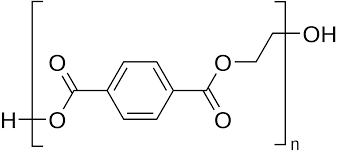

In [ ]:
Image(url="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAVEAAACWCAMAAABQMkvIAAAAh1BMVEX///8AAACcnJyrq6seHh7m5ubd3d2RkZGmpqagoKDOzs4EBASMjIzu7u729vbj4+M/Pz/ExMQrKyuGhobX19fz8/O5ublSUlLIyMg1NTWXl5d8fHzs7OxZWVnS0tKysrIhISEUFBRmZmZMTEx/f39xcXFERERAQEB0dHQRERFXV1cvLy9gYGDVCWufAAAJ8ElEQVR4nO2d6WKyOhCGGVdQQXGt+25r6/1f3wESJEh2I+h38vyogjToK2EmM5PoOHz8VobgUIsUC8jwq34z5dDOPvH+Bc3X9qt+yguaf0fGdcz2B17QfK3xgkY/hbpV1DBWUdNYRU1jFTWNVdQ0VlHTWEVNYxU1jVXUNFZR01hFTWMVNY1V1DRWUdNYRU1jFTWNVdQ0VlHTWEVNYxU1jVXUNFZR01hFTcNQNKgf/obz8xZvTkfT9JXeSFzUYBWl7AX4O+6iv2GyPYJl+hJAR9ioVfSRNsBiEj36J4DkMu3BKX2taxXlQ1N0A/B1fxmajlVUBZqis6yPO7/w41hFVdgWFZ0AZMYnhPgAqygft31ncYN2jujlLyBU9hN5ezBKd1ytogU60CXIb0AQuUowII4G2MSKNuYYa+uLXNfEBqXXT+FCbKWKXgYJF6toARdWxBbFMoWwyzYCgLHt9VwC6JGbFEX7ABNyI7CWicsyLyHNe2pA/f68ltwCrKJs+jDNbdMUrUE3fRp1+vh4qyib4yC/TR2FNuASJE8mA5jFj1ZRJmFsZ0ioiq72AL1wHI4AvpMdVlEmcH7YwYjm9fBkJxdtnpKxKGrBKkpSK0yBY0acx9Pp9D4FMZgE6dPJhH587jT/G0UnsHjcZWP4T3EuymcVfYYxjsiTWEWfYX4p7rOKPsEUKJPdraJPQETmM6yi+rQhoOy1imrjg0vbbRXV5kD/lFZRXTaMwaNVVJfhjL6/VEUn/X7zBaczzKrfX4mPqgPjo5SoqPuXRF8OY9qL74I/QjGiniB8EWR5ogdKU3Q1jMT06r055NMy78U0EnPpukvIymrojJi6laVo0IUZ+tpDgPYLzmmEzv29jeAxkpyjD1vWS2UpeoJ5+jQka1bei2vWl5fAM6+zP+ZLZSlKBqrX1NHbGzAlq2l4/f4rLmJgUJKiucqfKexecFIDLLNUReTAM22P4+wP7EZKUrQGhPeWKwhQZdDY8WkUQ5bSbZPjSg+OTuzHU06x560GWJKibfLbD55Yn3DxUPlWYPGr/4mGZAAZlX81e5Rz9KbMJkpTdEGmDCf6ivpQEx0S6LsSf2QxwxYG7CM5lKSom5n6OJdADYPJcJB4u57293Ukv68FrNlHcihJ0Q0pYp2UVwlaXqcIz25w6ZEi/hbTnFKU5z1ltVQDcddlMD/KHMXzbbhEnec+ovd1veayFPWye2ddu9NP0YcM2f+OXuL433wumUty0+z05Y3rj9BFPn4NpLouDTQy8NndcYJiBk32GJHPCmCWXKX+TdvDKy/2FL3H4c/oBvqC4rzOocs+xEU94aT7qfoNgMvpdAH40zVvJUbzOudrJOf3QtfOr5D/zbdOjVv8lx1rE1KfxcG8Nc/jFDTwOTH8G2qVb52+UPyAGQ9+PZUpqrxQ/gZFLrYCEzzbJQ87Rs7i9VSl6ErZeGCNRHGrJnLTNoKIMZWafl/PqOwaXSqeGPfjntDzGqEjbup3Ht9IKLwKRZOrR9F44MOb9KqDHKgem1GfwENmiCumAkVDZDxcJeOB8zpriZ+YqKM7rfhqfkBuiCtxehOtPCC4RgdIlt2vfIvYZ+9IlKw7zp/cHfcRuSGukCoUbaEO2VEwHr9oXLmTGhlu0MUm8goeUDycSSWW6Yw65FraeODYR34CJpsb6gS0elk2ppJflSgaoHe/kjYee7WRkA9e/KB0Y1S+7bKoxnuqoR42kvwU+NqUH62nEQD5Dyf/7YqoyB/dIytAZp/Y4DwHp+qgAErCUObGsJC/A4moSNEwNR4yg1E8GFCJeuIK+YVsSE7FSgqoasx0ROf9+xa31kL5tFApMj9AaTeQTJDIORFSVKVoH3XIjYTxuKCsFNxU3sL9a5CqBDQZqqpsXH9CHVJsPLAoxQmYfPBsuKNMkjAwWS5YmaIB6pBi45EaGcUoBjZnLRlzdnqixqVAdRHnOrr2FoJrDxsXygRM0ZtADUv8NGLTaP1lhTH8YdQhg2aze1412fRRJnoM6qFLtGZQNCzgtR/hz769f+E+GnssU+cCQpJjW4/rAkgQoguvJz7FxgGFqI2AKvNM6+4UwhafsXa1BCa6Rvuc9r9g0W/F/uvH+6MxPhSWpChCnyooj2joiu+zA2O/7VtpLvQko5aE6hyEQ1fsObVQcMUAVSo6kerR1CnX0syE/qiHwjA/nx17QhyuUocN9Oo4E2TGTF0cKpSK2oipUFHZ8GVLw3NK6UqM63E42/vkGD5COq+j7t2nyBXn4qDW9XPzTAj5vI7yCDT7R6n4KC6aCD83F4pQyOuoRklSZC9u7GFdPjVfj1DK63SVInkp0kNXnMDqa9aJ56mu7kklryMZ5nxA3knA8dGliRhUVYr+quV1xG5lERVHFlVjBM+NJhAVKSpXHJKhkrVLUXEwcZ7J1eoLeSpSVDmvo1rKpxoQwAVVO915QRnVKCpbHJKhnLjw1Qbqq7RySHNOREZFNSXqZfKqX8JBMZiEfQ/tiTt3KlFUvQtHNJRuFOo1znhqj+J/FalCUb3pRmrGbKg8pPzo2jw9g7reyR9b15BneBIfI3VqI83kec3smxUxtVQEaKjzD8RHVZEfuLLXDno9uor+LNN7+HhZ8GvoijYXxyvsDk+4J+mVV3cZeChJ3FS4mh/pnObd7vykOfvZ0Vc0mysdFpfxoSoaL/Z1We8gnXGrwRan1dl5YmTgf4e6Z/DjdPcsnsh41B3im1C08P5pit7wjxD6Z9FyXxzmUjPptOfXx9nZ78Rsbuaw17yvlqUo/gnCmB5o3+XkvMydVuwvZgZ3p2ugVguYUZai5BoQQ/2qBpk6cPUhbgq5BkS/7DUguIp6u8c9Y/K6dDVXqXHkRuv6pYu5dUouJa9Tkn2bnUTRTc27496ubrblxRdkTsQn1tJxFuDxcW/6nlNuLZ12yWvpAOwbiH2iqMevBTO13lN0kxTWhennoitd7ylyL2aIb5leb2xNspdCWZNMHVO9Pgdt3TwicvHUunmvhLJunjol2fqQtEy5H3t8J3JrO5411zopSdGAdOsPH7/+KI+y/NGfbGW31vuukUsU5C9As6K0LEWjixSPQVpvvDR2dHPCd9I66A5lSxvXR0JCL+xsD2CqrPAVuABz7+vLu+g7YSYULTRBjT0FJ+QuDozUa72K1hq9y4P25BFdRYOA9hTDijiPw/DrPT1RgqAThpsn4vmfFMP/DKyiprGKmsYqahqrqGmsoqaxiprGKmoaq6hprKKmsYqaxipqGqxos+VM256p7I9V1HEWu8NsdDU1xdwqGkdaa3HBxtMTJRD/Q0UDHzPxUkXjy3P/5CorKbWdmXY+CHLFnmSHmzw0TCkK95pZz9CN5N1pdjKSHWYVJUt23j5m/yLMKmqxiprHKmoaNUX/A7ModifnRhnJAAAAAElFTkSuQmCC")


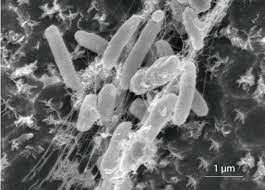

In [ ]:
Image(url="data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBYWFRgWFhYYGRgaHCQfHBwcHCUjJBojHh4kISMlIR8hIS4lIR4rJB4hJzgnKy8xNTU1HiQ7QDs0Py40NTEBDAwMDw8PEQ8PEDQdGB00MT8xMTE0MTE/MTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMf/AABEIAL4BCQMBIgACEQEDEQH/xAAbAAACAwEBAQAAAAAAAAAAAAAEBQIDBgcBAP/EAD8QAAIBAgQEAwUHAgQGAwEAAAECEQADBBIhMQVBUWEGInETMoGR0UJSobHB4fAUYhUjkrIHFlOCovEzcnNj/8QAFQEBAQAAAAAAAAAAAAAAAAAAAAH/xAAUEQEAAAAAAAAAAAAAAAAAAAAA/9oADAMBAAIRAxEAPwBLiMGfb3G/vf8A3miuJ8CfIrAEgies9xQGPxDe2umdBcf/AHGjsBxx0YMfMBAjlA7HpQWYfir2rORpzLoFjKEHpzNKeJcWN1MrgAg6RzptxKz7T/NGobzT+YjrSC/YOXMCe/bpQL1BJAG5rS8K8Mu6lnOVFUtpBmP1O1ZhkrceEbzoma64FsxBaZjnz2FEC+B8OTitUaADB5Ke/wDOVfeI+Bmy5ZmzFtZ7knad60XE+OYfDJmtSWJkFVOpO2rbUI2Ku4nDPedFLKwiTqBEa9P3FFYm9gnYSIj1oFrRBI5itFhOG3b1xkdIlDlgwFK6jn8/Wh7nBzZDPdZRpEAyQTpr86IRquutaXw7hQLTvlltxOxjYDqaU4zBZHAIldDp9ofzSrOI497jqiSFBGRR15UVN99NJAMDWPWSaUX7cGtGti411UcDOfuwJMbk0v4nYyOQwjWI+PKgUrb67VTdtGZo115Dbn61JMKWE9N/SiAV8onr+XP6UbwZiHEaZtP1/Q17huFXsQ7C2hbKOXIbVreCeGnVkzoTGwI0XXUk/pQazht0FFGQDMsr1AGus7n60s43xAlWQIMyjfrtHlOmlNMTiksiURiRPlmSewPMDoKjhuEJo94Z3P2QYCjp1OlFYThBAu5nOiiSMsztr2rVW3QoXRcoJkjf5/n8aXeKOHW8MjXLKea4fdOuo5DnGs/CKG8L48ubgdoJ3EbEbkdf2NA7XijqIADLsJ3X17VLDcRYmWQhG8uYiBPb8aHw9ou2WSAdJP5/hTe5dywoGi6fCgS43CHcDevuHWoOu3SjcZiEtI7tOXeACfgByNI8Jxy7fAXD2chYwrsc0Cd4AifjQDeLr1xsSlpAHlVARhIAY+bQRrzJma33BsKiKFGjxqNY25f+6VcK4AEd7rwXJjNpI11J700vsAGyHQ7HoAYJk7tyFBn/ABdiyigZxlBJgddcqnsNzNc0vuxYknU9a0HiG5/nFMwbKOXczy5wRrWdc60RYLhykcpH871J7rQoze6I/n5VBiTrFeqtBAya9ynrRd7DlInSRPLY7VVQM+J//Nd//R/95qlRpzphxZFW5cM6m4+kf3HnUb+EfJnZCFPPlp0op/wQe2tZEUr2XWSNyBv8K+4hwgqjrMtHnyeYLBkhj1/tHSknAuMPh3zJG0Qe+5HeBTdsa6OHQkBiCREyDvQZ7EcHdYcZWG8nQfHNFLsZincZGbyjYDb8KY8T4jcd2lyRPSJ+HKvuDcGbEXAk5V3YnkPrQK7l92VFkwm3w2p/wTjTo6883/yA8xMactq22E4NhkT2QthhzY+83edx6Csn4g4P7F4TRTqOsd/5yoJpxVxcZRIUhiADpoJ17aUkbEnEXJfRQCzBeQGpiTvVt3EIqwD54IIjYHTeheFWXZyERnlSCF3APOToPjQV3MaufnkEhRtlBM17w7GZHzhA7Dadlq/H8AvWzJRgvUj8yNJoJLbKDofrRG+4LxpHRrjWwXgroQMs/dmTJBrHcZt3GdrjoVBOk7fOvuGvCOW0OkD8qCx197nlz+XoTQU4d9ctafg/C2vgqhKgDzMV2nmDt103pTwThguOEUyd3PJQK6DhyttAiaKv49zRRnD8ImHt5Lfl5k/ac9Sf0qHEuLm3lUmS/wBkiQY5npvUlcZZPqSeQHSsVxO6+JxHs0nXduijl26mgf4O4t52fXKjQCOZ97TtWit8QtvMypA1EflSa3bCItpPdUfPqTXyNHpQKPFuPZ5VRACyO0sBPrE7Uj4ZYeyCY0bYH+b0TjMUC75dSROYjQAMNqAbiIVx59YhlP3dzHfn2ig1HDsYpuoq+9MwaeYpcrk6GawuHt+fPOkSI5iNK2Vq4Hto0yYE+vOgKucPS5bKH7XP8RHxqPDMAbR1QZF90DVif09KvwFwGFbToen7UcsJzDE/IDrNAJj7oC5D5JEkjkBv8dfyrJeI+Oqltsjeb3UAHujrrzj86o8ZcefP7NDqfeA1heQ9WNZkYe9iHKk5Vtjz9jEx68qAfAPmYjctzrzE2YbWtZgOAeywz3FAZiQJPLpA/WlnE+FgKzq+g3B0Opj470CcoOW1FYG2jZixjKJy7ZhtoeomY5xVQwrBc3LsZ/Kj8Jg0Fv2j+Zvspy33Jn8KICxLSZ0gQAOUDYd6h7bsv+kUYOHMUa4xyiRlXrPQchzob2Hag13G7NtMUyuVR3DQAAYzH4gNE99aPw2G9ompLZEEJvmAMQOQ6k0n4zhXDPdu29BcYBiNWhiY3mNN+9JU47czMWWRyCnKAOnOitceDJedyiLbtrq7z5UgawTvrpA3pbi8Qgtrl94SAx5idNOor7D8auX7ZtmURdfKYUjo1K+I4zPlUAAIIEc/WgXvcM9e9aTwhxBEcq5AZjl131219RQHCeHEh3dfKiMdecDl8YpMLwDSN5EHpFB1t3A1FA8duE2HYKGZVPyjl6b1Hh+LF2yjg7rr68/xq1GBkNsdCOs0HIL1wkmetdD8AOn9OY0cuc3U9PhFY3jfDxavsjbTAPY7GmHhi3ct3iyHyBfP3+E6HvQdHvEj6H996X38PbIIKIJ6AA/AjaqsPxu1dJCOCRuOYqbvvQZTjXhgnzWmLf2sdfh1pLgMAFuKrhpJywNwToK3t1svOp8PwquTeKCUkIx5E7x3+tBXw/hyYZCi6u2rtz9B2FX2Vk1B9TvRS31thZjM2ij9fSgF428JlGg3P09BufSlnh62Qj3mEZ2KoP7QdT8Tzphew3tCF183vH7o571ZfYABV0UCAKCOefjvSnxJfbIEUxOrx90cvUnSmyQFLHkJobhjq7M5AL7665RQZPiVx0XKAc1yGIj3QRoPz/Ck962toktOdhtvE8t9+tdSuMrjzAHl/wCjXNfEfDCl0+bNPmE7kSeuhjtQRwWPIR1ziQJUEHadf00rXf8ADp7lxnV5KkyCRoPT+dKwHCA39QnKWg+hBB/Cuq8D4hCIPtMMwiPdUiJI2Lb/ABoHdzDlHg0P4l4wlm2qtJd1MBNwBude+nqadYq1JDAaEaVh/H99Ua35hmjaJMAzv3JoMdZxSLcLusa5jJzHtpGw717/AIoiM7KWIckhTynr3oA4dgpJGrHXsB1/nKqzY6GiNlwnjXtlKBypMHIBvAyxHbSmmP8AD1x7cACIzb66GOW4rAYNCjq6nVSD8q3uG48jGA0QOZ5HUiisumFe0+TLuQGB5gnnT7F2raNkdj5RogUxqftGKeLhbZzXQQyosgxrqRHqRSjj99jkuDUOummxBg6daCDWGvhERHzaBZjKQJ30BG9M/wDkXE/2fOlvAuOOjas08tB8pOorSf8ANt/oKADE3MyOWHtELuPNJI1IIBnSCNqyNjBe1ylEyLPmPQDnBP61q2tl1uWEdkYlmEGATnaZ0oK1a9haCypDKQ2bcHeQaCC2LTpktvCrzgwx79aymKORyo3B+FF8Su6BVJjc8taVvadmACsxPKJJoLGxb+YAkSII5R6UNFMrvCXt2faP5SzQqHc76xyFAW0J5TzojXeDMVAa0T/cv6/j+daIGGrnnC7rWrtt2BC5oJ7HQ/WujukwZopR4k4N/UIrqYZdDPMfUUNgLKpZa1mI3zORBIHTflWltNuOfLnryrmPFeL3SWTRSGMncn4mg94qtpCotB8xYEseQ9evPSo4TxJdtnI83BMTsf3pYru51YnqOXqK0/BeAu1wMySgeTPOOQG7cqBxhcV7YIwPvjQHc9YrRYkKihF2H58z60RgfD6+1NwiAoIXSAdo9f0qrE2ZJNABbWTSjEYgvdLRKqNB6frTji5KWiFBzNp86VcO4eweHBhRL9+g7igZW2KJP2m5dByH60Hnk61dibsml+MxYtoznkPxoKsfxIZwg5e98eXyq7AkJcbpEDvtWbwL5yXOsn51tuCcG9qFd5C5sygaFgOp5L3oPGOpEcp+X7Uo8Q8JbEWtEdipkZRr6VvrNhZ0VUQakgan05k1NeIS2VDlUaAD9aDlGA8PvYdGIZ2IJC6EJ5dc5nfXQCtN4eKvcfKkDRQ55sBOg5KoIFaq7w0vcR8xCEEMswNo+NSscLCTlAG8AaRJ1+NAm8QcYeyqrbMLESYhY3O/8Nc441eZ3BUswjVydW3kg9+1aLxlZYFgWgCAQ0ygOoEAak9dtKxNsKWWQSs/zagKWy7EIobYSI+O/XWpYnDezYDeRPzqd/FXS/s0YJsBGg00A7VoG4fmRTfZFbkZGp3jTf0ojLIDM0TcykACQedOsXh0ypbSNJZj0nlPQb/E0nxQAJAMxzoLrHEryQquwUCMvKO/WjbfEWdPZkgAmdeXp070lUmauw6FmoGjgWzBYTz0mKNy2v8ArH/T+9K1t5mJ0OX8Z2on+u//AIJ86K2eI4kgdyyJ5XPUTDc+vpQPEMSmJZiiwSQAo76fLvSDiONZb7kfZd+/2jyrQ8Ax1q2huygk6mCAO2skTQG2vAYkG4x9BEmn44MlqCiKWVYDGJMDaeg2pBj/ABwzqz2rbsFIhgCAvaedLn8YPeQB2jWCOvUSNvX8aBJ4w4krkqwHtAeROg210j9az2HuaiWCgETvrWm4rwRbre0tHNm3HMHp6Uxw3hRFtDP77b6+76cqCnE4FrqSmXJEmVE/9pG5+NMfDmKL2craNbOU9YHu/hp8KhwrhzqrIzgqemux0/DlV1jDth7oBAy3NC20dDE9aAoEg71iPFvCyLxZEJDiRA58/r8a3+JtZTtVfs8w/uG2sb7wYNBz/g3hO490KzBRBJKsJBHLWur4XCW1RAgGdMsgfgQee35UFw10VS2WWnUsQC2nWNuwq29jQHUJJG0ndeemvegsu3mLqzsff8qdAOvblMV9icUi5mYEEco6DrSc8QLOS5E8vTePXSquK8YQAALLRLct+VATwPFtiCwdFVkbMBpok6a7E/WpYpwA51ksdTuY03qfhZcqu2ZR5YUfjG/equIt1Edht3oEtw61DEeH3xKBX8iZpHm1aRvl6chPemvC8AHbO/uKf9R3j0plexpZ/KAB+g2oFfDvClq2AzzlXZT9qPTlTy5jfLlCwO382qi5cJK81UDnVTt55OoI2n8KCTX2fSYGwFW4a1ReGe3knUHkuv4/SrLMLqcqiNT9BQGYe4kamMvX9t6DuO2YyZ15VVhMQXuPIAVOXMnv9KhicV5vpQZj/iCgKA7MyEE9QhBA9d65vwknPAAjdiTpHU8q3v8AxLuj2VoScxLaDYjSZrnNtCMx28v56UGzweHthDdBVn2VZ8uY8550s4lce66qxGmgVToD8OdA8NdEtLIJDscwG+nSj5ABZdOnUd/Wg8xgyqAfSOegjXp6UrdyasvvOgnv3NVWkJMQT2FESsLmYKNzTnG4b2FtSSc77r0HennCvDITJcLHzDTy9ep+zFEeLeEILefMCyjltE+gjr8KKzfBXzMyFZzCQfTrTr/Cz9yl3BMIXsPdCmbcAE7an016b19/VP8AdHzoKscha7dA++/+41VhldHDrqIhgwkFeYK8xRmIb/OuRvnf/caPw1tGhWGRjvm0B+dBqsTgVewFQKqZAytBykkiRl0kmdO4FZC/4bZRCNPM5tJ9Ke3uOolq3bGqKSW3JOmkdp0oTF4oXkY58mYwN46x2MUCO5Zu2lktAnkw3+Bpvw7iLNaZnbQEAE89Nh1/eka8MJzEe6upY/vS3E4g+6CcoOgmg1q+IUSYEnvFCY/xMzRPmA2WND+tZEua+uOTQdSwePF1FZoVyNR0PSrLRIPY1zpcKzhZuBbq+7LbgRznQitxw1Lh99hsPLEMNN2k7egoHLWrWQEqfKdwT5uex0nvSjFYvPcCpoA0HnpBkfHQV7xq25UIgJY/ZUTIA5DrIO3Wl+H4NiUdLroWJ94MRKg+nTTTtQA8SRnuIiE6tGm8+m59Kd3PDSMfPcImJAHIDaZ/KhvCfDnTPibvvklUH3F5n1P5U7tOCw1/n1oIBChCctwRzUR8JrziS5jI2OvwoviN4ABZiZj5c6xXGOMXFR8jHoD+AgUGuwDf5Eepn415gQmeXO+3z10/KsVwDxj7JksXULCMpee51I6c5rU/4thc3luoxOuVSGIHwOwka0DHGYIo2fOhT7InX0jr37VXjsTYtqC75dJ1A0nWkp4obltrtpRkkgaa6HVteURpFA2OBLjFckOH+07ElV5QoPblQPsHxgXfJh1mTBdhAXuB1ojHuYFtX295mO56/OruCcOWza9miloMBuc8z2HICh8Zw+9qVCmOU6/L96Bnw8BLZ2J0BPXpQF24sj+RVfCrxay7EEeeADp7oA5671G0ZPxoMn/xLxGtlRvlYz2JH0rF2rxyMTrJA1+NdJ8UYBb8psyjynv09DXOcbgmtDKw1kn8h9aDxbg000pnhroZcvPvSdAKMwtyCNKIvxAiINWcExrW7gKxBPmJ6DU/Grblg8xE7fGhmwpEyKK2eC8S3mQ3JASSAgXvoSSdaE494hS5ZylfOw1UD3SNv53pJg3dRkk5CZI/fcVPDYP2t2XIC5pMbHXYUG08MrOGRGlQw0jXaRrVX/Kzf9Rfl+9HYa+iWTmBGX3BGu8GR051D/mzDfeP+g/WgzmJwntblw+4fasDroVk+Yd9DSjHYhRCqWgTAPKep69qJLsmIvXGkwzhFO7y5HlHMCjMRhrF5cylkuwM9uJ+INAlsYl4idv58qdcMxKN5WELvpzP/qlr2BlnQfr84/KpWyYUKJoGfiDFIsWkMJALEc51115TSi3w5bgOS4pYDRdj+NT4nZIMnmB8NKGwbuGBR8r7DSf5+1BbxfhvsMqAZmiWedNtQByj1pcuHcqxA21PYVpMTfDIDccB9iSAFfpp16/OkuNxBRGQA5m0JPIfvQLOHv8A56MdYYGOscv0rq/AMOxY3c8W8o0fXUdTOpFckwiHOgX3swroqcfQItkEZk0Eb7xPxoNngEAZ7pBB1VZGvcnn8qhiGLHevVfKqidFEdyefepZ0aJPmMxA0oE5vf5eu5Y/7iB8KGD1ZiUKmCIgmPnULac5oAeKuSVHQfnWd40QuUEbeY/Db5mKd4l2a40rCLABP2jv8hSbjaFiSdQBJA5xsJ9edAg4VwJ8S5M5V+03Qdu529K0Q4BbQqUlSum51B3B9ad8HsKmHEaltT6n6bekVXduss0BXhrhBto9oNnJMiejaflFbHB8KWxYyEkT7x2JJ1gdqTeFEJXOTDLovoeZphxLGF2CAyBQfPilQBUEAaD40IHM1K1hiUZ25bd4/Sp4JAzDXYz8qCHE2gKpOsfjQuEXWr8d5mOs/ChMdiVs2nuPsBHz0oFF5yzs3U6Uq8V8MzoLy+8ujDqDz+dObEOoZYIOoopbQZWQ7MCD8RFByUA7c6OwVmdelD4tIcgGYJE0VgGIaBzoi+5c2EyenSrhi3A+tC3SAaJw2CZ10I03HMDuN6KiMa0RAir+HcRKNMD5flQj2fUfrXqWwvvUGqxOJFxQwc5nEEdZpf8A4M3WliY4iBpHpV39b/cfkKCGPxBW9dI943HljvGc6A8h6VJMWqXA411UnnpzH6VDGJmv3QBr7R/95q7hrJbdXcB4OqRIMiKB/gPCRxKO6OB5jBnysCZEnkwmI7U2seCTaTPduLlQyQupI3+dDv4nCMEGUIp8ioNGMe8Y0y8vjR3CPGSujq+TP72U6CNt9ZAFBheNuc0rGSTljXbkT1FDcOwj3G8isY+0BoPU0047bNzM1se85MKI0iAQu8Ulw2NuW4Uscg3Xl+Gs0DnHcCC2s8kkEhj1OYj4e7Q+JwjXLKQNQcrSPkZ6QI+FMeH+JhmRcjZdASTqemnMdZPworE8f5C0FVR5yI5dgNSdPnQZy1hVsQTDO0kdlAkn00qPhW2bmKVmBMnMfRdRPy/AU8W9bxCs5Q7ZQNQeRIFO/DXDrQcun3dNesToOQjfWgb4ozEHXpXmFTQA/wA+NWPh9JO5MCkfiTjX9MmUE5m+6RKjqJkTOnzoHPEkRoggsNDHL170EylV/XWk/D/Ell7RAzB2gny6s8a67HbU0Qt9mUGWjtv6fjQX4zAIilyxLDUjl8+lYXiWMd3YgZURxJiNAJJ9OgrYuj4hvZKdDq55AT15j8zTNvD2GVAhTP1LE6/AECg57gOPOp/s3Yfd0+laXAX1xEFDMn5Ur8Z8MtJkFsC3nmdNDHM6z8hT3wRwxECi2Gd2XzE6ZRqZjlPLnQaHh2GyS/JQQPU9vSgsQ5LaCtFjME8QBlVVOp0mP1pClskxFAd7cumQLqdCZ0q7D4QZg06oCAOsjelfGeIphrZ185+evSedZfAeL1tEs5Z50ZpHLaBMTQbS4J/Wsl484sqlMMsE6M/aBoPXnTJfFFkoHQSW1gwMvcidfQVl8Xgs917rMbjtqTGkRyA5fpQLuH8fNliCspG3ftTLEeM5UqlvLIjMTtPYVBcMhAGQTqM0SRPOOcUHxW3bsotsAO+55Azzkaz2oEyKGaJ1NEWLRB15b1HCKGupuAWAPaTWg9hD5SDmO4IkeWdSOYjXvRCbFrJJHwo/gACTdYgcl6kzyqL2VYmXBb0gen7UOiHv5fd7UVoeOugVXEBiDMdf52rJtcM0RicSSipHuk69Z1oM0Es1fZu1eKtSk/eohtxJCb9wD77/AO41BAqTOrR8qecRdFZ2VfMXcT/3H8aE4XwcXS5Z5yjNC9OW/M9KKUZWd4QSd/QevKj8H4Sv3TIKLzkuBr2ijbyiyuiFBzB974/yKBueI3ClbZC6+91HoefegDuNdss9svqCQw39daEO/avrWZpJMk6kk60dZCL70igZYbH2hbS2iszxqWGs8o5QPn3ptZ4acmVk5eY6xJ/UD4UDwRbaE3SA5GiA7ZuveK0lq6bh28z6lG5Dt/OlAhfhz5QgUhDr5TrA3JaCD8KWYPGXUv8A+XAMQ0+6q9I7VpcY/sszScw5SSNpgKNNO1KGxjtYa4yjPngQIzaaHrAIPxoLuK+LnXyqEBA1Jkxr02FY7E3Xvv5iWcnePz5CKjeu6+eSZnpJ5SOg3+Ipz4TtIrhm+3Ghg+hOnWgc+GOBh2CWnXOg80giM25E6H9q0HEOE3bdhUWMwJ56nqQDr8as4xizZQOkKxPlgdP2/OkhR8TiLZuksNyJ0hdfxP50Gh4Jw42rKyQHfViTEaSBG+gqR176wKuvDO0A68hH0oz/AAaU3Obl015/CgWcQ8IpeZXaM0eUkE7axEgfDn1p5gMHbw1s+zWGbVmOpY9SenarVZkC5nnIoE7Tp+dLn4ipkK3PnQW4rHsyxJ13n8qUcR4omHttef7I8o+83ICmlxVZRECsh4s4et+AzZFQ+Uz13Pr9KDAca4v7fzmQ7GWEkj0B6dqToKe8bwSK4VIywAI/M96EXAke8QNJoj3CFmYAbwB6xWg4Tbm4qszeZoheR23pFhrmQ7UdZxTMfISvWKKdWLBS4zakgmNSfSeURSJlN29cYkQNM3IR39BUsRjXKlJBEQTzihsLisgI67/GPpQXWHA1K7RGv7U04bxg50D6AjJPPXSc3Ko4DDC+pCAqy7Ts3oevrQeI4eyEhhHrQNeJYfDW1OV2e4eWUgL8eZkRSf2pyQOutVFiTvPr+9F4a3troxg0ALLzqsrpTDFYQgmBQy2jzFEDVZkHT8avFkV77LvQOuK4glnUDUXHH/l+FV8G4guHR2IVnzAgHfTTcev508xHD2Fu+XSZdigA11c+Zj6bVkksyfz7UUZxi+b9wshYzG5n4bbCrreHtJbAe0Z5sGlieo0gCgf67JIXQHcjc9pPKqb+N8vl3aQR0H1oDcNbQOCFzKTsdx2Ov5VVxTAqbirbacx907pGupGkRrQ2JxIhXQwToRGqnp6dKnatMEIUzcfRyT7ixOp78/Sgml8ZjDAIggTz+XMnWmCcYd7ZRHaWMTtP03GtZvE3Boi+6P8AyPU04wtj2dj2pEsRCj1Op+UUDLhuIzv7FZyW9z1jcn4z+FBY7iua8yIfIqkbwNP5vUsS74fDf33NyBGUdPWkdkMiNCqQYzZuXQaEHv8AHtQCx7RydhsPj+0/hWm8JWizvdceRBt6AAD5ileS3k1kF9cvQcgT0nWm39UUsIiwC3maJ2E5R+vyoh7jcULqiIAGwO8/a/AD5U74Dhcqe0PNcq99dT+XyrPeHuGtcKM5ESYAGrSOfQCtfeuj3V0CiABRXthgGn5GnFjEB0DAmF2O3/rWlFpC3lXcg+g0pw1v2dhVbU70CnjWKGUCZjnO5/mlZ7DQzwTHemWIlwY3BqGC4U2jkwo1mNT8KBh7RdUGgAABNIfGKKiB21IIiDvIP4aTT72IMvr9fhWT8SXkuTOYBeuw6jfnQY04xPebQj+2QaZ4i2jgPJhtQQJGvek74V7jajKg6D+TTzhWPS0mTJmtxswEs08hOnPWgTthNTGvpUlw4G5itHjrdpklGyRuvMD0FZa7dE+WgidTUClW4dcxiQBzJ0ozE4FkjNrOsj686IK4bjEtBVXc+Z26abDqdqt8QcQzkQAAVGtKRaM6HQda9uuPX1ooTNTDDuNzppS496kHG1EaWzjky5My+pH60Jimy6Sp9Kv4V4fuFw7r5Infrt69NKO8UcGdV9rGUQAViIjTp+XWikZctoN+wrz2Td6v4Xh5Q3RqE0I5knbtRP8AUp1b5ftQbTjN7Kzq6goScxLADfbeTXPOKX0mLZ8v83p34pxDPcfzT52AH3YPTrWUumJFBS7E1FCZr6aJwyAedh5Rp/8AY9B+tETs2CsORJPuL949fQVLE3vZqUBl31c9OwojF3yuRiACyzl6DkOwnWOdJySxncmgK4ZgTccD7O7HtW0wDq4JgZBos/2sR+k/KguGYQIgSYZx5j68p9ARTL+lUKEAhAN40n9etFfX8LnBRoMtMbgaQB9aB4jgrSWmzHuY3Jnr+FMEAt6MwzHUwOm/pVHE7YuI6gaxI7E7CPSaDE4S2166F6mTHIDf8KMLSXd5VFO3bSAPlTjw9gDYD50lrgyj+1dz86G8S4B2CLbTyTEKPtGN+nSg2/h24GQOuwQZfiPp+dEFiTWa8BYzKz4bMDkAjuZOb4A6CugpdtEDNlmPdyH8CKAbhaMT0XbbedKYcVWW7AR8q9tPK5gNtVXpHM9QKvxTjJnfTsOfegS2uFZvNMRqKU+JfFiYUrbCl2Ikr90dSep6V7hfE0XnV2Fu2q6qVLMTylhou48sSZrl/F72fEuWcMWYktsI5RO2lB1vh3FluKXRg6MPLAjJAGm/vTOtZjxViEcqGBUkif7oO1ZvCcVNuAilUmTHMjnpUDxDPnzn3iWA6E9KDR4rimHW2fLECAJkntWfs4tGcHKACdhy6a0HcwoCK/WoW8o1B19KAri1kZ4JApYbYG1MsSwuDMTDcx19KHt2WI0U69v586Aa1ZLMqgbnnW2wFy2Ua2SCqCJ5A5eX8/KsgEI1B9Y+VEW72QhhsJ0O2oigniSHcIrBQTGZpgT1ygn5A0Pdwbi5ctxmNouHI2AtsQza/Z0oYXvMG00M/IzTXh/FUOIxFy4ul5bsqp53STAaDGpiYPLSiKk4LiGkpZdo/GUD6CZJyMGgawZ5Go4CwLV8JiLZJOWBuIYSDIMFSDuJpre48SylbajISQMxO+HWxG0+6gb1pJicSX9nAC+ztLbGu4WdfXzUG9w3iCyyALa8luQrkxrOy6yBQ/iXiVt8OSr6Mvlk6nqDWU4fioT2WUQT73b05mqv6U3buRAYnSfsiaK2nhjCo2FyIqy4GYnTMRPM96W/4Le/6bfMfWtFwu2iWgAQPZ6akagnkeoOnypt/VJ97/zX60HOvEuLQ3XyZgc7Bp7NyrNuxNOOMiLrjnnfX/uNJnGpFBLDKubzGBzoy9jFzAgSF90dOvxPWl5ECr8NaBLE6heXU/SiPSpbNccmOXc8gKIw4SyVZxLnUL93pPftV8bM2sbDkPQcqW4kSxYmSdaBrb41kJcDMz7jpGgHar8Bx12dFAbfeZ77Vm2NaHh1r2Vn22haIHain120zuIbKg3jckcpry7iwrZfL2HPvS/E4028JmA1cDnsTpP4TWesYpggadT+AHfqaDcpdDt7pBA5nad/jUsc7izcVIUlfe6QeRjQ9PWsnb4ybPkCzpqZ66mnXD7zYi4qEwI19B07zQV+DeHMjC4ghiQvm1kHUx9a6FaK5obWPxoOzhFtEBJ8s78ydzVhOhPPWgfWr5KnLkGmhCzH1pdxO+coVmzN3G3T40TgrQGHBiJkmNKRYgzQZzxDahsze4TmYDSW21O5+NYp+HO7llQxMg9a2/iS6CoQj1I5/tXlziKC0f8ALAyLpFBlsPgTKqzZcwkd6oxVjK0DWjLfEMzBsoHm0A5fGo8UUl9DE/p/6oKlxAKBGIAkweQJ60z4VetopUi0zHZjrBoHgnCibkuVYRMfwUR4jtLGZQFjkABQCcVv2s7ezk6/DvHar/DrEs5JOQDVT7tI7TTpR1q60BJ0UzHJjM60Dzi/DUQB1jKwkCdo/Gs//VuDKsy//UkflyoziGKLW0zEkyQenwHoaUUBZ4hd/wCrc/1t9a9s4y8T/wDLc/1t9aConAvBI3miGV3il3T/ADHH/efrUxxd+bv/AK2+tLHXzV5mkUUc+PDQWLM33iSdOgmr+FYxFeWzddDE+vOlLpFSsrNBtcfiWKeTLkI0UcjvPesz/QP92rcPjYga6bUV/ijfyPpQf//Z")

The ability for this bacteria to degrade PET is attributable to something called a protein. Proteins are the "doers" of cells - they help cells communicate with each other, regulate cell metabolism, are key players in the immune system, and perform many, many other functions. A particularly important type of protein is an enzyme, which catalyzes a chemical reaction. By catalyze, we mean that the enzyme makes the chemical reaction go MUCH faster, making enzymes absolutely essential to our bodies being able to function. A major goal in microplastics and plastic research is to create enyzmes that degrade plastics extremely fast, so that microorganisms can break down plastic pollution for us! In this activity today, we will get a glimpse of how computers can help us understand enzymes and identify conditions that will allow plastic to be degraded as fast as possible. 

# Computational Modeling of Enzyme Reactions

A useful way to model an enzymatic reaction is the steps 

E + S -->  E-S  ---> E + P. 

There are two steps in this reaction:

1. The substrate/reactant (S) binds to the enzyme (E)
2. The enzyme converts the substrate into the product (P)

How quickly the product, P, is formed is described by the Michaelis-Menten equation

$$
\frac{dP}{dt}=k_{cat}E_{0}\frac{S}{K_{M}+S}
$$

In words, this equation is saying that how quickly product is formed ($\frac{dP}{dt}$) equals a fairly complex expression involving the total enzyme concentration ($E_{0}$), the current substrate concentration ($S$), and the parameters $k_{cat}$ and $K_{M}$ which are properties of the enzyme. The efficacy of enzyme can be attributed to its $k_{cat}$ and $K_{M} values.  

We will try to get a better understanding of what this equation really means by tracking the reaction progress for different values of the equation parameters In the box below, input different values and see how the behavior of the reaction changes. See if you can answer the below questions:


-How long does it take for the substrate, S, to be completely consumed?

-Does the rate of the reaction change over time? If it does, why do you think the reaction rate changes? If it doesn't change, why do you think the reaction rate is constant? 

-What is the effect of increasing E0? Can you plot by hand how the long it takes the reaction to finish as a function of E0?

-What is the effect of increasing KM? Can you plot by hand how the long it takes the reaction to finish as a function of KM?

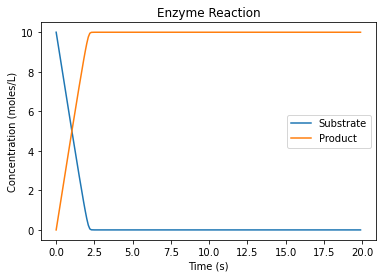

In [ ]:
#parameters
S = 10.0
P = 0
kcat = 10
E0 = 0.5
KM = 0.2
time = 20

fig,ax = plt.subplots()

MM_Eval(S, P, kcat, E0, KM, time, ax)

To visualize the effect of KM and E0 together in one plot, we can use the below function which will produce what we call a color plot. If you have never seen a color plot, the plot can be read based on the color: sections that are yellow react slowly, sections that are blue react quickly, and sections that are green are intermediate. Try playing around with different values and see how it changes the plot. As before, here are some questions to consider:

-Does E0 have a larger impact on the time required to degrade the plastic completely than KM? 

-If you want to make the reaction go very fast, what kind of KM and E0 values do you want? Do you want KM large or small, and do you want E0 large or small? 

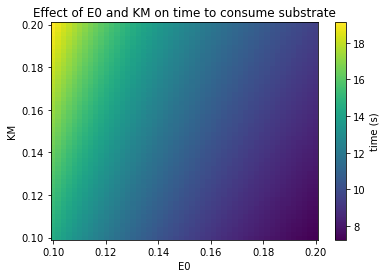

In [22]:
#specify parameters for our calculations
S = 1.0
E0_min = 0.1
E0_max = 0.2
KM_min = 0.1
KM_max = 0.2

#run the program!
MM_2D(S, [E0_min, E0_max], [KM_min, KM_max])

Another important property in chemical reactions is the temperature. To get a qualitative understanding of how the rate of enzymatic reactions are affected by temperature, we can run the below cell. In words, how would you describe the effect of temperature on the reaction rate? 

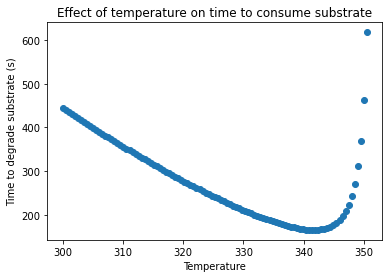

In [27]:
MM_Temp(1.0, [300, 350])

It appears that increasing the temperature makes the reaction go faster until a little more than 340K, then slows down dramatically! Why is this the case? The answer is enzyme stability. The ability of an enzyme to accelerate a chemical reaction is strongly dependent on its shape or structure, and the structure of the enzyme falls apart at high temperatures. No structure means no reaction, and the reaction takes a long time to complete. To get a qualitative understanding of how _kcat_ changes with temperature, you can run the below cell.

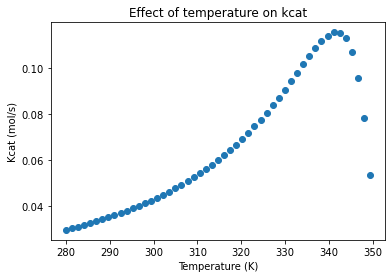

In [30]:
KCat_and_T([280,348])